In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/ANN

/gdrive/My Drive/ANN


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
dataset_dir = "Dataset/oversampled_dataset"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

In [ ]:
test_data_gen = ImageDataGenerator(rescale=1/255.)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 186 images belonging to 8 classes.


In [ ]:
model = tfk.models.load_model('Models/Model4/NoDropout')

In [ ]:
predictions = model.predict(test_gen)
predictions.shape
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  

6/6 [==============================] - 22s 4s/step


Accuracy: 0.629


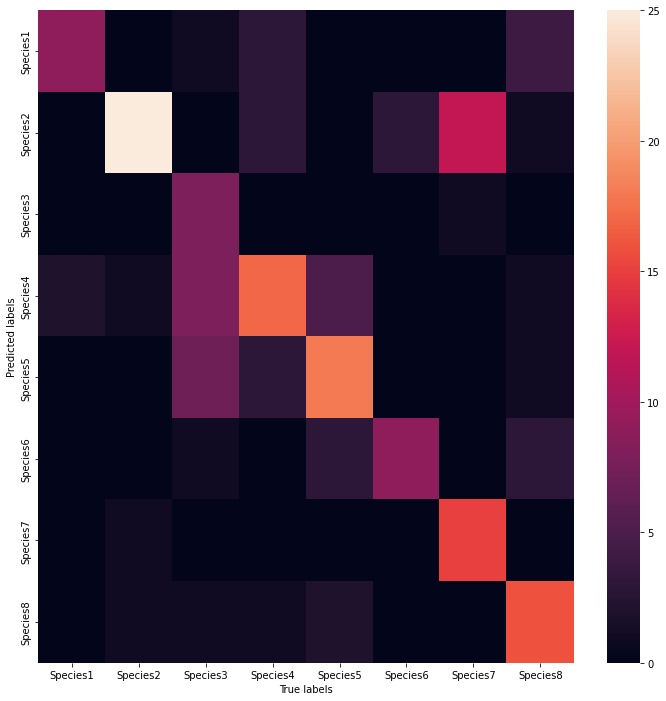

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
#precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
#print('Precision:',precision.round(4))
#print('Recall:',recall.round(4))
#print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm.T, xticklabels=list(class_labels), yticklabels=list(class_labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
model_test_metrics = model.evaluate(test_gen, return_dict=True)

print("Test metrics")
print(model_test_metrics)

6/6 [==============================] - 2s 295ms/step - loss: 1.1850 - accuracy: 0.6290
Test metrics
{'loss': 1.1850308179855347, 'accuracy': 0.6290322542190552}


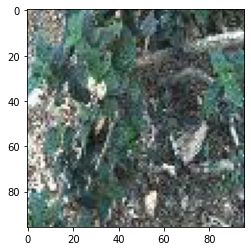

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[24] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [ ]:
#We can use this information and design a new model that is a subset of the layers in the full VGG16 model. 
#The model would have the same input layer as the original model, but the output would be the output of a given convolutional layer
#I consider all con layers:
layers = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model.input, outputs=layers)
#Making a prediction with this model will give the feature map for that convolutional layer 
fmaps = activation_model.predict(tf.expand_dims(image, 0))

1/1 [==============================] - 0s 88ms/step


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth, first_n): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

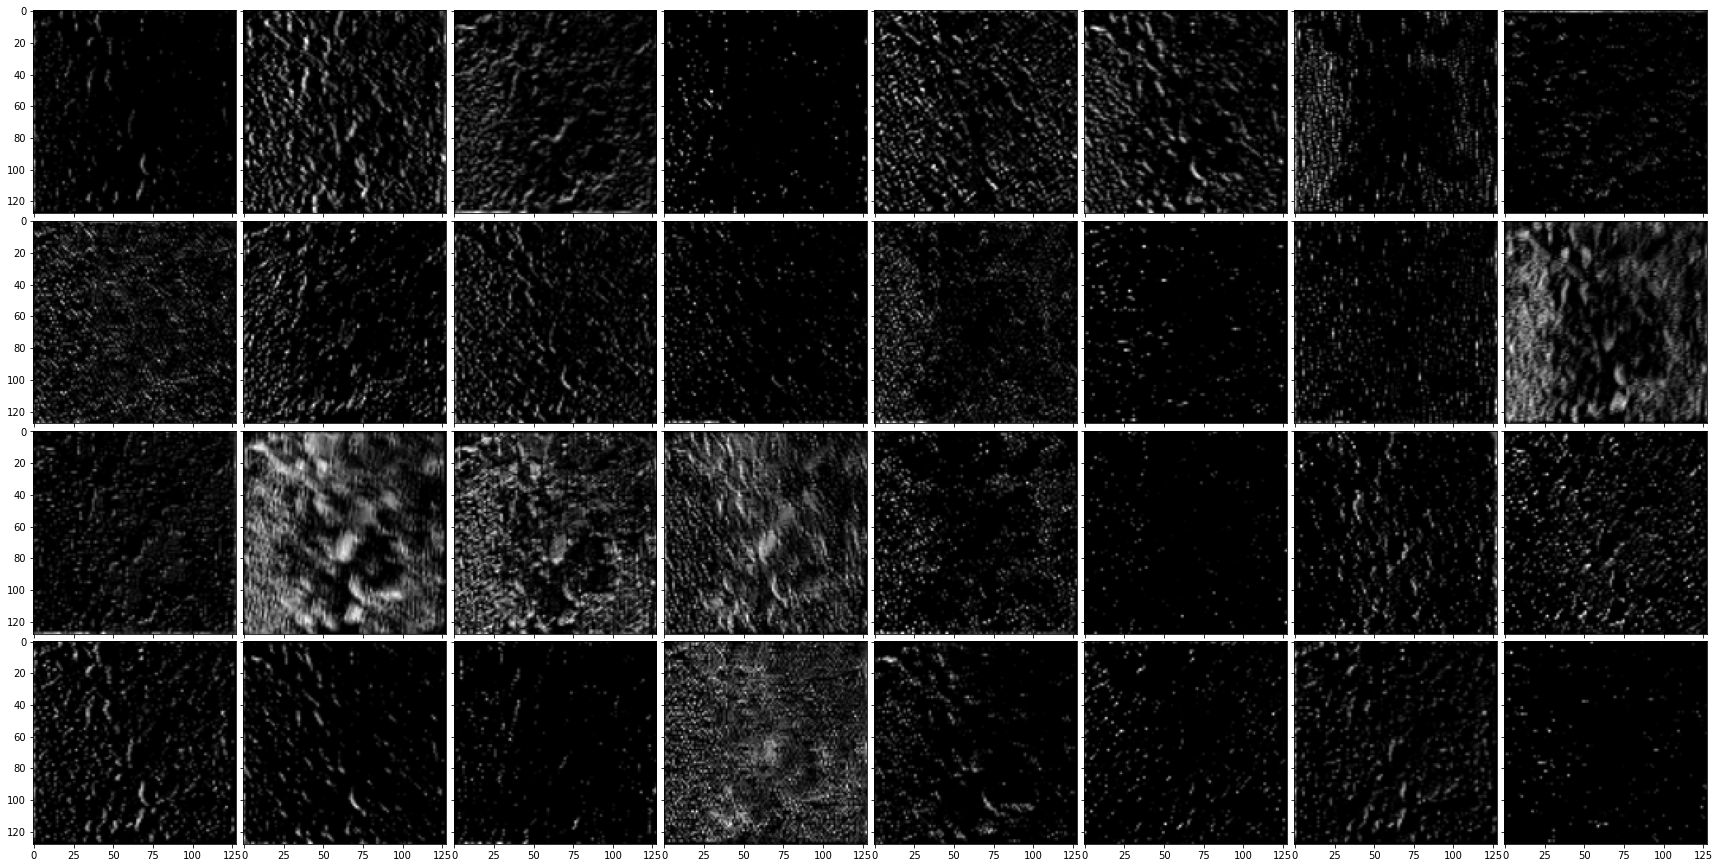

In [ ]:
#We know the result of the first conv layer will be a feature map with 96x96x64. the second 48x48x128 and so on. We can plot all 64 two-dimensional images 
display_activation(fmaps=fmaps, depth=0, first_n=-1)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "Models/Model1/Checkpoints"